In [1]:
import os
import gc
import json
import math
import cv2
import PIL
import re
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
#from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import glob
import tensorflow.keras.applications.densenet as dense
import seaborn as sns

In [2]:
train = pd.read_csv('D:\ISIC/train.csv')
test = pd.read_csv('D:\ISIC/test.csv')

In [3]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
train.shape

(33126, 8)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [6]:
test.shape

(10982, 5)

In [7]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


#### three features do not exist in test: diagnosis begin_malignant, target

In [9]:
train['benign_malignant'].value_counts(normalize=True)

benign       0.98237
malignant    0.01763
Name: benign_malignant, dtype: float64

In [10]:
train['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [11]:
np.sum(train[train['benign_malignant']=='malignant'] == train[train['target']==1])

image_name                       584
patient_id                       584
sex                              584
age_approx                       584
anatom_site_general_challenge    575
diagnosis                        584
benign_malignant                 584
target                           584
dtype: int64

In [12]:
train['anatom_site_general_challenge'].value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [13]:
np.sum(pd.isnull(train['anatom_site_general_challenge']))

527

## there are 527 samples which dont have anatom_site_general_challenge

#### benign is 0 in target, malignant is 1 in target,  9 dont have anatom site who are malignant
## the data is extremely imbalanced as shown in the graph below

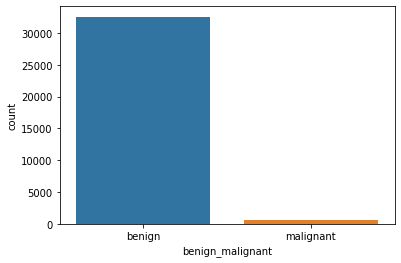

In [14]:
sns.countplot(train['benign_malignant'])

In [15]:
train['sex'].value_counts(normalize=False)

male      17080
female    15981
Name: sex, dtype: int64

In [16]:
train['target'].groupby(train['sex']).mean()

sex
female    0.013766
male      0.021311
Name: target, dtype: float64

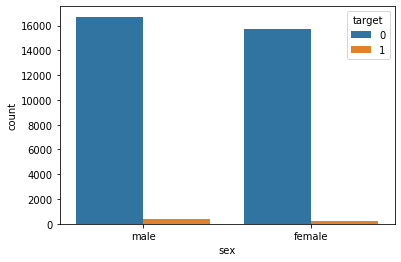

In [17]:
sns.countplot(train['sex'], hue=train['target'])

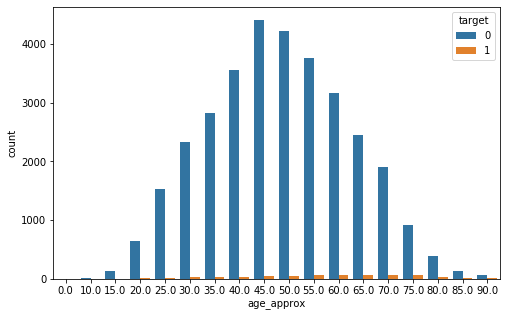

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(train['age_approx'], hue=train['target'])

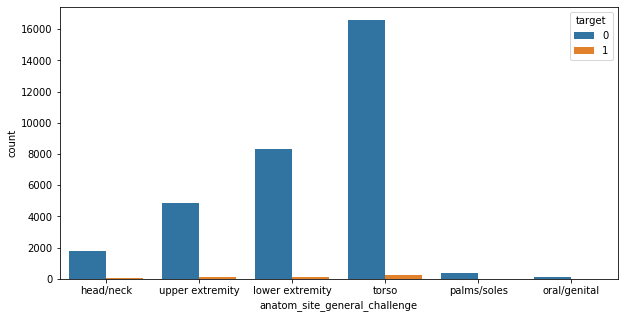

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(train['anatom_site_general_challenge'], hue=train['target'])

In [20]:
train['diagnosis'].value_counts(normalize=True)

unknown                               0.818813
nevus                                 0.156765
melanoma                              0.017630
seborrheic keratosis                  0.004075
lentigo NOS                           0.001328
lichenoid keratosis                   0.001117
solar lentigo                         0.000211
atypical melanocytic proliferation    0.000030
cafe-au-lait macule                   0.000030
Name: diagnosis, dtype: float64

In [21]:
train['target'].groupby(train['diagnosis']).mean()

diagnosis
atypical melanocytic proliferation    0
cafe-au-lait macule                   0
lentigo NOS                           0
lichenoid keratosis                   0
melanoma                              1
nevus                                 0
seborrheic keratosis                  0
solar lentigo                         0
unknown                               0
Name: target, dtype: int64

In [22]:
np.sum(train['diagnosis']=='melanoma')

584

### all melanoma are found by doctors.XD

In [23]:
np.sum(train['diagnosis']=='unknown')

27124

In [24]:
train_df = train[['sex','age_approx','anatom_site_general_challenge','diagnosis','target']]
train_df.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,male,45.0,head/neck,unknown,0
1,female,45.0,upper extremity,unknown,0
2,female,50.0,lower extremity,nevus,0
3,female,45.0,head/neck,unknown,0
4,female,55.0,upper extremity,unknown,0


In [25]:
train_df.shape

(33126, 5)

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df = train_df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
train_df.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,1,8,0,8,0
1,0,8,6,8,0
2,0,9,1,5,0
3,0,8,0,8,0
4,0,10,6,8,0


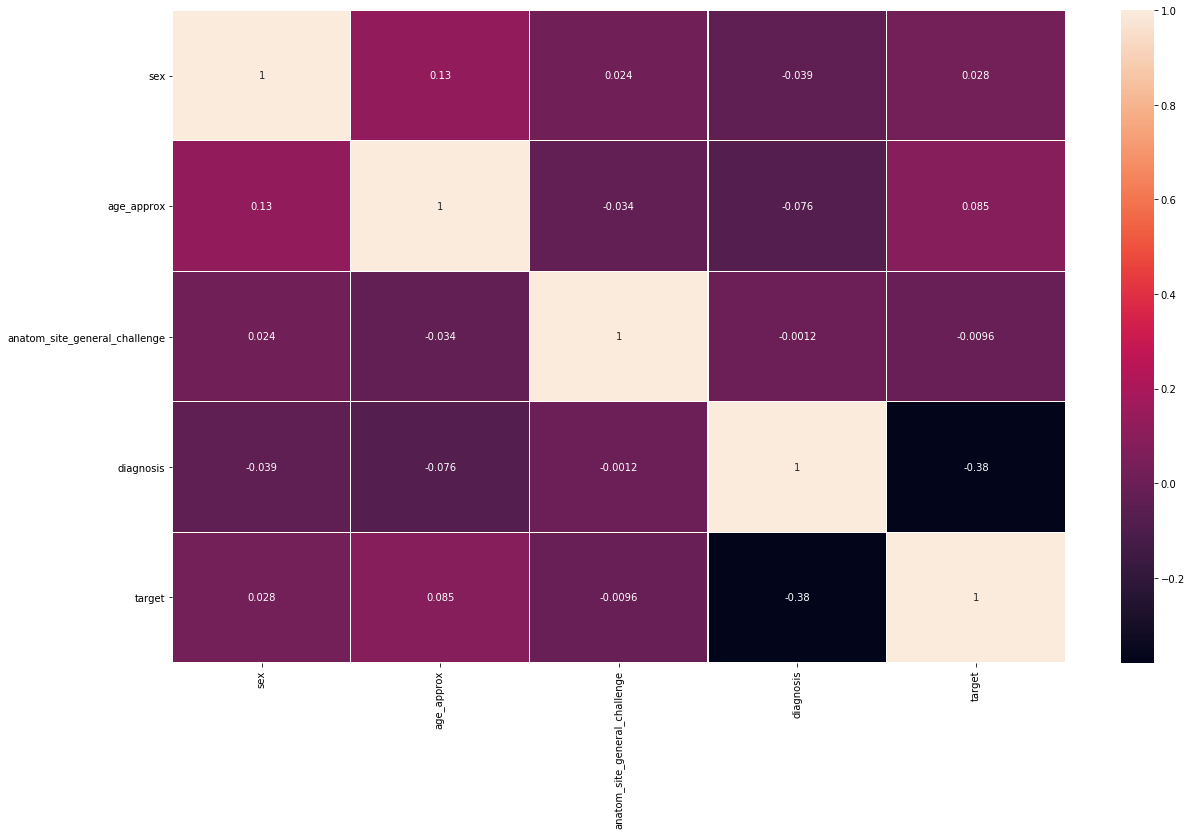

In [27]:
sns.heatmap(train_df.corr(),annot=True,linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [28]:
train['patient_id'].value_counts()

IP_4938382    115
IP_4479736    115
IP_4382720    115
IP_7279968    115
IP_0656529    114
             ... 
IP_1005794      3
IP_9675066      3
IP_1334660      3
IP_7442038      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [29]:
test['patient_id'].value_counts()

IP_3579794    240
IP_6877747    108
IP_4288676     93
IP_7746230     90
IP_2848061     80
             ... 
IP_5235058      3
IP_4150574      3
IP_4943808      3
IP_4271334      3
IP_5615339      3
Name: patient_id, Length: 690, dtype: int64

In [31]:
train['image_name'].value_counts()

ISIC_3665859    1
ISIC_1488725    1
ISIC_0924215    1
ISIC_5488982    1
ISIC_0412482    1
               ..
ISIC_9643846    1
ISIC_4511027    1
ISIC_5204245    1
ISIC_2327808    1
ISIC_9333245    1
Name: image_name, Length: 33126, dtype: int64